In [11]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
from voxc_sv.data_loader import SpectrogramDataset, AudioDataLoader

Populating the interactive namespace from numpy and matplotlib


In [12]:
import numpy as np
import random

speaker_wavs = {}
with open("/home/muncok/DL/dataset/SV_sets//Identification_split.txt", 'r') as f:
    lines = f.readlines()
    for line in lines:
        set_id, file_path = line.split()
        speaker, file_name = file_path.split('/')
        if speaker not in speaker_wavs:
            speaker_wavs[speaker] = [file_path]
        else:
            speaker_wavs[speaker].append(file_path)

In [13]:
all_speakers = list(speaker_wavs.keys())
enroll_spk_size = 5
test_spk_size = 10
enroll_uttrs_rate = 0.3

In [14]:
E_speakers = [spk for spk in speaker_wavs.keys() if spk[0] == 'E']
# random_speakers = np.random.choice(E_speakers, enroll_spk_size + test_spk_size, replace=False)
enrolled_speakers = E_speakers[:enroll_spk_size]
test_speakers = E_speakers[enroll_spk_size:enroll_spk_size+test_spk_size]

speaker_id = {}
n_classes = enroll_spk_size
for i, spk in enumerate(enrolled_speakers + test_speakers):
    speaker_id[spk] = i

In [15]:
enroll_X, enroll_y = [], []
dev_X, dev_y = [], []
test_X, test_y = [], []

for spk in enrolled_speakers:
    wavs = speaker_wavs[spk]
    video_names = []
    for wav_path in wavs:
        video_names.append(wav_path.split('/')[1].split('_000')[0])
    video_names = set(video_names)
    total_video = len(video_names)
    enroll_set = random.choices(list(video_names), k=int(total_video*enroll_uttrs_rate))
    test_set = list(video_names - set(enroll_set))
    for wav_path in wavs:
        video_name = wav_path.split('/')[1].split('_000')[0]
        if video_name in enroll_set:
            enroll_X.append(wav_path)
            enroll_y.append(speaker_id[spk])
        else:
            dev_X.append(wav_path)
            dev_y.append(speaker_id[spk])  
            
# testset for test speakers
for spk in test_speakers:
    wavs = speaker_wavs[spk]
    for wav_path in wavs:
        test_X.append(wav_path)
        test_y.append(speaker_id[spk])  

In [16]:
sample_rate = 16000
window_size = 0.025
window_stride = 0.01
window = 'hamming'
noise_dir = None
noise_prob = 0.4
noise_min = 0.0
noise_max = 0.5
vox_dir = "/home/ideal_kar/Dataset/voxceleb/"
split_file = '../../../dataset/voxceleb/Identification_split.txt'
audio_conf = dict(sample_rate=sample_rate,                                                                                                                                                            
                       window_size=window_size,                                                                                                                                                            
                       window_stride=window_stride,                                                                                                                                                        
                       window=window,                                                                                                                                                                      
                       noise_dir=noise_dir,                                                                                                                                                                
                       noise_prob=noise_prob,                                                                                                                                                              
                       noise_levels=(noise_min, noise_max))   

from voxc_sv.data_loader import SpectrogramParser
parser = SpectrogramParser(audio_conf)

In [17]:
from voxc_sv.model import siameseNet, voxNet
import torch
embedding_size = 1024
model = voxNet(1251)
checkpoint = torch.load("models/voxc/voxc_384_wo_E.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

voxNet (
  (conv1): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (fc6): Conv2d(256, 4096, kernel_size=[9, 1], stride=(1, 1))
  (fc6_bn): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True)
  (fc7): Linear (4096 -> 1024)
  (fc7_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (fc8): Linear (1024 -> 12

Speaker Model

In [18]:
from torch.autograd import Variable
import numpy as np
base_dir = '/home/muncok/DL/dataset/SV_sets/voxceleb/'
embeddings = np.zeros((n_classes, embedding_size))
for wav_path, label in zip(enroll_X, enroll_y):
    audio_path = base_dir+wav_path
    audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    embeddings[label] += emb

speaker_model = np.zeros((n_classes, embedding_size))
for i in range(n_classes):
    speaker_model[i] = embeddings[i] / np.count_nonzero(np.array(enroll_y) == i)

In [19]:
speaker_model.shape

(5, 1024)

SI using speaker_models

In [20]:
from scipy.spatial.distance import cosine
def spk_verify(spk_model, test_in):
    best_score = -2
    for i in range(spk_model.shape[0]):
        signature_uni = spk_model[i]
        score = 1-cosine(test_in, signature_uni)
        if score > best_score:
            best_score = score     
            pred_spk = i
    return pred_spk, best_score

def pairwise_cosine(spk_model, test_in):
    scores = np.zeros(spk_model.shape[0])
    for i in range(spk_model.shape[0]):
        signature_uni = spk_model[i]
        scores[i] = 1-cosine(test_in, signature_uni)
    return scores

In [30]:
correct = 0
for wav_path, label in zip(dev_X, dev_y):
    audio_path = base_dir+wav_path
    audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())[:,:100].contiguous()
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    pred_spk, score = spk_verify(speaker_model, emb)
    if pred_spk == label:
        correct += 1
print(correct / len(dev_y))

0.8797953964194374


### ROC Curve

In [28]:
score_vector = np.zeros((len(dev_y)+len(test_y), n_classes))
label_vector = np.zeros((len(dev_y)+len(test_y), n_classes))

i = 0
for wav_path, label in zip(dev_X, dev_y):
    audio_path = base_dir+wav_path
    audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())[:,:100].contiguous()
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    score_vector[i, :] = pairwise_cosine(speaker_model, emb)
    label_vector[i, label] = 1
    i+=1

for wav_path, label in zip(test_X, test_y):
    audio_path = base_dir+wav_path
    audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())[:,:100].contiguous()
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    score_vector[i, :] = pairwise_cosine(speaker_model, emb)
    i+=1   

In [31]:
score_vector

array([[ 0.67731838,  0.3292623 ,  0.42586993,  0.39137931,  0.36746581],
       [ 0.63776803,  0.33844087,  0.41042283,  0.40937092,  0.37472511],
       [ 0.6510691 ,  0.30322995,  0.42769412,  0.42713643,  0.38735483],
       ..., 
       [ 0.4393064 ,  0.4644121 ,  0.54034221,  0.43764833,  0.45749345],
       [ 0.51161668,  0.52329863,  0.60519074,  0.58489368,  0.60045286],
       [ 0.5034771 ,  0.40867359,  0.49670422,  0.47476029,  0.50801359]])

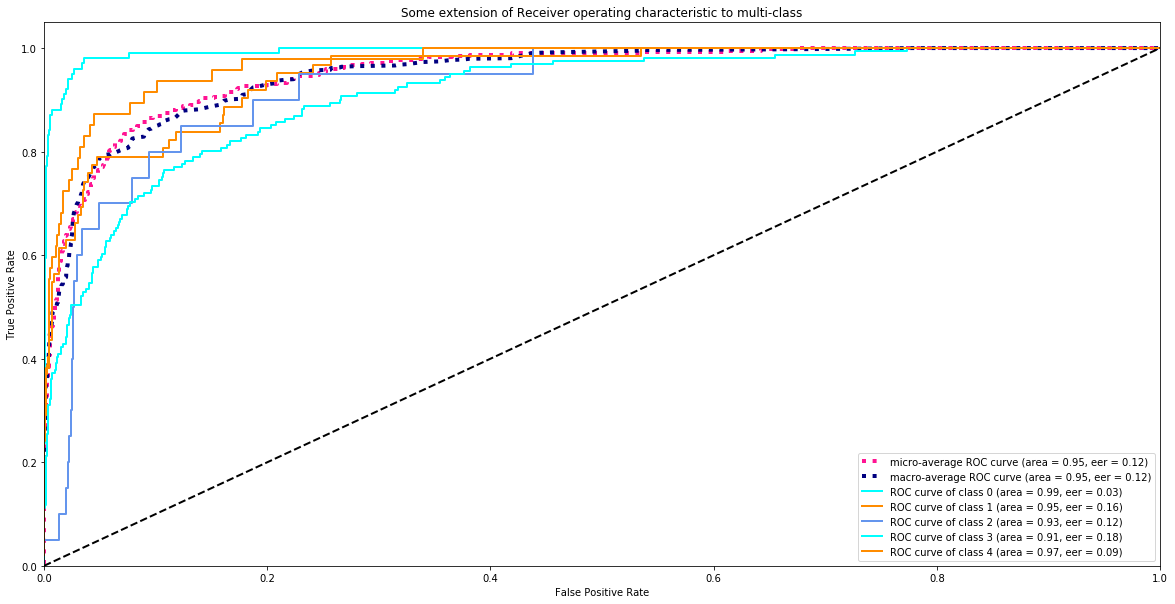

In [29]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f}, eer = {2:0.2f})'
             ''.format(i, roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### False Accpet & False Reject Evaluation

In [96]:
sample_rate = 16000
window_size = 0.025
window_stride = 0.01
window = 'hamming'
noise_dir = None
noise_prob = 0.4
noise_min = 0.0
noise_max = 0.5
vox_dir = "/home/ideal_kar/Dataset/voxceleb/"
split_file = '../../../dataset/voxceleb/Identification_split.txt'
audio_conf = dict(sample_rate=sample_rate,                                                                                                                                                            
                       window_size=window_size,                                                                                                                                                            
                       window_stride=window_stride,                                                                                                                                                        
                       window=window,                                                                                                                                                                      
                       noise_dir=noise_dir,                                                                                                                                                                
                       noise_prob=noise_prob,                                                                                                                                                              
                       noise_levels=(noise_min, noise_max))   

In [205]:
main_spk = 'micro'
margin = 0
global_thres = thres[main_spk][np.nanargmin(np.abs(fpr[main_spk] - (1 - tpr[main_spk]))) + margin]
print(global_thres)

0.63357417547


In [117]:
test_X_arr = np.array(test_X)
test_y_arr = np.array(test_y)
print("False Reject")
for spk in enrolled_speakers:
    nb_false_reject = 0
    test_wavs = test_X_arr[test_y_arr == speaker_id[spk]]
    for wav_path in test_wavs:
        audio_path = base_dir+wav_path
        audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())
        output = model(audio_input, 'fc7')
        emb = output[0].data.cpu().numpy()
        scores = []
        is_user = False
        for j in range(n_classes):
            score = 1 - cosine(emb, speaker_model[j])
            if score > global_thres:
                is_user = True
                break
        if not is_user:
            nb_false_reject +=1 
    print("For {:15s}, False Reject: {}/{}".format(spk, nb_false_reject, len(test_wavs)))

False Reject
For Eartha_Kitt    , False Reject: 1/103


In [118]:
# test_speakers = list(set(E_speakers) - set(enrolled_speakers))
false_accept_record = np.zeros((len(test_speakers), n_classes), dtype=np.int32)
print("False Accept")
for i, spk in enumerate(test_speakers):
    nb_false_accept = 0
    test_wavs = speaker_wavs[spk]
    for wav_path in test_wavs:
        audio_path = base_dir+wav_path
        audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())
        output = model.forward(audio_input, 'fc7')
        emb = output[0].data.cpu().numpy()
        is_user = False
        for j in range(n_classes):
            score = 1 - cosine(emb, speaker_model[j])
            if score > global_thres:
                false_accept_record[i][j] += 1
                is_user = True
#                 break
        if is_user:
            nb_false_accept += 1
    most_close_spk = np.argmax(false_accept_record[i], axis=-1)
    print("{0:20}: {1:3}({4:3})/{2:3}, {3:20} ".format(spk, nb_false_accept,
                                                len(test_wavs), 
                                                enrolled_speakers[most_close_spk],
                                                false_accept_record[i][most_close_spk]))

False Accept
Ed_Westwick         :   0(  0)/ 73, Eartha_Kitt          
Eddie_Griffin       :   0(  0)/ 50, Eartha_Kitt          
Eddie_Izzard        :   0(  0)/240, Eartha_Kitt          
Eddie_Kaye_Thomas   :   0(  0)/ 54, Eartha_Kitt          
Eddie_McClintock    :   0(  0)/ 74, Eartha_Kitt          
Edgar_Wright        :   0(  0)/185, Eartha_Kitt          
Eduardo_Noriega     :   0(  0)/ 67, Eartha_Kitt          
Edward_Asner        :   0(  0)/187, Eartha_Kitt          
Efren_Ramirez       :   0(  0)/ 63, Eartha_Kitt          
Elaine_Cassidy      :   0(  0)/ 67, Eartha_Kitt          


### Sweep the threshold

In [105]:
if sweep_interval > 10:
    sweep_interval = len(thres['micro']) // 5
else:
    sweep_interval = 1

th_sweep = [th for i, th in enumerate(thres['micro']) if i % sweep_interval == 0]
under_test_spk = 5
sweep_result_fa = np.zeros((len(th_sweep), under_test_spk))
sweep_result_fr = np.zeros((len(th_sweep), under_test_spk))

In [124]:
th_sweep

[0.81718872082108229, 0.63357417546953942, 0.31877660137056973]

In [126]:
print("False Reject")
test_X_arr = np.array(test_X)
test_y_arr = np.array(test_y)
sweep_result_fr = np.zeros((len(th_sweep), under_test_spk))
for k, th in enumerate(th_sweep):
    print("threshold: {}".format(th))
    for i,spk in enumerate(enrolled_speakers[:under_test_spk]):
        nb_false_reject = 0
        test_wavs = test_X_arr[test_y_arr == speaker_id[spk]]
        for wav_path in test_wavs:
            audio_path = base_dir+wav_path
            audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())
            output = model.forward(audio_input, 'fc7')
            emb = output[0].data.cpu().numpy()
            scores = []
            is_user = False
            for j in range(n_classes):
                score = 1 - cosine(emb, speaker_model[j])
                if score > th:
                    is_user = True
                    break
            if not is_user:
                nb_false_reject +=1 
        false_reject_rate = nb_false_reject / len(test_wavs)
        sweep_result_fr[k][i] = false_reject_rate
        print("{0:20}: {1:3}/{2:3}".format(spk, nb_false_reject,
                                                    len(test_wavs)))  
    print('-'*30)

False Reject
threshold: 0.8171887208210823
Eartha_Kitt         : 103/103
------------------------------
threshold: 0.6335741754695394
Eartha_Kitt         :   1/103
------------------------------
threshold: 0.31877660137056973
Eartha_Kitt         :   0/103
------------------------------


In [125]:
print("False Accept")

for k, th in enumerate(th_sweep):
    print("threshold: {}".format(th))
    for i, spk in enumerate(test_speakers[:under_test_spk]):
        nb_false_accept = 0
        test_wavs = speaker_wavs[spk]
        for wav_path in test_wavs:
            audio_path = base_dir+wav_path
            audio_input = Variable(SpectrogramParser.parse_audio_ext(parser, audio_path).cuda())
            output = model.forward(audio_input, 'fc7')
            emb = output[0].data.cpu().numpy()
            is_user = False
            for j in range(n_classes):
                score = 1 - cosine(emb, speaker_model[j])
                if score > th:
                    is_user = True
                    break
            if not is_user:
                nb_false_reject +=1 
        false_reject_rate = nb_false_reject / len(test_wavs)
        sweep_result_fr[k][i] = false_reject_rate
        print("{0:20}: {1:3}/{2:3}".format(spk, nb_false_reject,
                                                    len(test_wavs)))  

False Accept
threshold: 0.8171887208210823
Ed_Westwick         :   0/ 73
Eddie_Griffin       :   0/ 50
Eddie_Izzard        :   0/240
Eddie_Kaye_Thomas   :   0/ 54
Eddie_McClintock    :   0/ 74
------------------------------
threshold: 0.6335741754695394
Ed_Westwick         :   0/ 73
Eddie_Griffin       :   0/ 50
Eddie_Izzard        :   0/240
Eddie_Kaye_Thomas   :   0/ 54
Eddie_McClintock    :   0/ 74
------------------------------
threshold: 0.31877660137056973
Ed_Westwick         :  72/ 73
Eddie_Griffin       :  50/ 50
Eddie_Izzard        : 240/240
Eddie_Kaye_Thomas   :  54/ 54
Eddie_McClintock    :  74/ 74
------------------------------


In [108]:
th_sweep_bundle = {'false_reject': sweep_result_fr, 'false_accept': sweep_result_fa, 'threshold':th_sweep}
np.save(open("th_sweep_{}spk_npy".format(under_test_spk),'wb'), th_sweep_bundle)

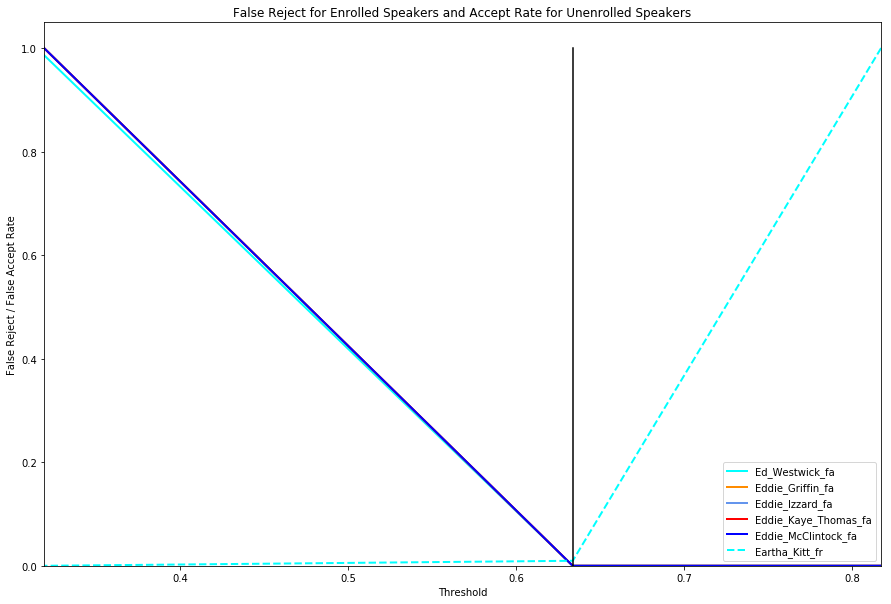

In [130]:
x = np.array(th_sweep)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue'])
plt.figure(figsize=(15,10))
eer_record = np.zeros(n_classes)
for i, color in zip(range(under_test_spk), colors):
    y1 = np.array(sweep_result_fa[:,i])
    plt.plot(x, y1, color=color, lw=lw, label="{}_fa".format(test_speakers[i]))
    
for i, color in zip(range(n_classes), colors):    
    y2 = np.array(sweep_result_fr[:,i])
    plt.plot(x, y2, '--', color=color, lw=lw, label="{}_fr".format(enrolled_speakers[i]))

plt.plot([global_thres]*10, np.linspace(0,1.0, 10), color='k')
#     idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0).reshape(-1) + 0
#     plt.plot(x[idx[-1]], y1[idx[-1]], 'ko')
#     eer_record[i] = x[idx][0]

plt.xlim([min(x), max(x)])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('False Reject / False Accept Rate')
plt.title('False Reject for Enrolled Speakers and Accept Rate for Unenrolled Speakers')
plt.legend(loc="lower right")

plt.show()

In [53]:
th_sweep_bundle = {'false_reject': sweep_result_fr, 'false_accept': sweep_result_fa, 'threshold':th_sweep}
np.save(open("th_sweep_{}spk_npy".format(under_test_spk),'wb'), th_sweep_bundle)

Model tying

In [98]:
print(enrolled_speakers)
tied_speaker_model = np.mean(speaker_model, axis=0, keepdims=True)
n_classes = 1
test_y = np.array(test_y)
test_y[test_y < enroll_spk_size] = 0